### 8.1 시퀀스-투-시퀀스 모델, 인코더-디코더 모델, 조건부 생성
* 인코더 : 입력에서 현재 문제와 관련된 중요한 성질 감지
* 디코더 : 인코딩된 입력을 받아 원하는 출력 만듦
* 입력과 출력 사이의 매핑 : 정렬

[S2S 모델의 핵심 구성 요소]
* 양방향 순환 모델
* 어텐션

### 8.2 강력한 시퀀스 모델링 : 양방향 순환 모델
* 과거와 미래의 정보를 합침

### 8.3 강력한 시퀀스 모델링 : 어텐션
* 인코딩에 최종 은닉 상태만 사용하는 제약이 있기에, 긴 문장에서 전체 입력 정보 감지 어려움
* 출력을 생성할 때 관련된 입력 부분에 초점을 맞추는 어텐션


1. 심층 신경망의 어텐션
* 각 타임 스텝은 은닉 상태 생성
* 어텐션을 사용할 때는 인코더의 최종 은닉 상태뿐만 아니라 중간 타임 스텝의 은닉 상태도 고려


[용어정리]
* 인코더의 은닉 상태 = 값 = 키
* 디코더의 이전 은닉 상태 = 쿼리
* 어텐션은 주의를 기울이려는 값의 개수와 차원이 같은 벡터 하나로 표현되는데, 이를 어텐션 벡터 = 어텐션 가중치 = 정렬 이라 한다.
* 어텐션 가중치 + 인코더 상태(값) = 문맥 벡터 = 글림스 -> 디코더의 입력
* 다음 타임 스텝의 어텐션 벡터는 호환성 함수를 사용해 업데이트

--------------
* 콘텐츠 인식 어텐션  
* 위치 인식 어텐션 : 쿼리 벡터 + 키만 사용  
* 소프트 어텐션 : 어텐션 가중치는 일반적으로 0 ~ 1 사이 실수  
* 하드 어텐션 : 0 or 1인 이진 벡터 학습  
* 전역 어텐션 : 입력의 모든 타임 스텝에 대해 인코더의 상태 사용  
* 지역 어텐션 : 현재 타임 스텝 주위에 있는 입력에만 의존  
* 지도 어텐션 : 동시에 훈련도는 별도의 신경망 사용해 어텐션 함수 학습  
* 멀티헤드 어텐션 : 트랜스포머 네트워크, 여러 어텐션 벡터 사용해 입력의 다양한 영역 추적  
* 셀프 어텐션 : 입력의 어떤 영역이 다른 영역에 영향을 미치는지 학습  
* 멀티모달 어텐션 : 이미지와 음성처럼 입력의 형태 다양할 때  


### 8.4 시퀀스 생성 모델 평가
* 참조 출력이라는 기대 출력으로 평가
* 모델의 출력이 얼마나 참조 출력에 가까운지 점수로 매김
1. 사람평가  
*  좋음 / 나쁨 을 표시하거나 번역 고치는 방법
* 에러율, 평가자 간의 일치율
* HTER
2. 자동 평가
* n-그램 중복 기반 지표
    * 참조와 출력이 얼마나 가까운지 n-그램 중복 통계로 점수 계산
    * BLEU, ROUGE, METEOR
* 혼란도
    * 출력 시퀀스의 확률을 측정할 수 있다면 적용 가능
    * 과장된 지표, 모델의 오차율에 직접 반영되지 않음
    
### 8.5 예제 : 신경망 기계 번역

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [3]:
def describe(x):
    print("Type: {}".format(x.type()))
    print("Shape/size: {}".format(x.shape))
    print("Values: \n{}".format(x))

In [4]:
abcd_padded = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
efg_padded = torch.tensor([5, 6, 7, 0], dtype=torch.float32)
h_padded = torch.tensor([8, 0, 0, 0], dtype=torch.float32)

padded_tensor = torch.stack([abcd_padded, efg_padded, h_padded])

describe(padded_tensor)

Type: torch.FloatTensor
Shape/size: torch.Size([3, 4])
Values: 
tensor([[1., 2., 3., 4.],
        [5., 6., 7., 0.],
        [8., 0., 0., 0.]])


* pack_padded_sequence : 패딩된 시퀀스 압축
1. 0으로 패딩이 많이 된 것은 밑으로  
1 2 3 4  - 4  
5 6 7 0  - 3  
8 0 0 0  - 1  
2. batch_first = True -> 첫 번째 차원이 배치 차원인지
* 세로로 읽기
1 5 8 2 6 3 7 4
3. batch_size는 세로로 읽기  
**3**(158) **2**(26) **2**(37) **1**(4)

In [5]:
lengths = [4, 3, 1]
packed_tensor = pack_padded_sequence(padded_tensor, lengths, 
                                     batch_first=True)
packed_tensor

PackedSequence(data=tensor([1., 5., 8., 2., 6., 3., 7., 4.]), batch_sizes=tensor([3, 2, 2, 1]), sorted_indices=None, unsorted_indices=None)

* pad_packed_sequence : 압축된 시퀀스 패딩

In [6]:
unpacked_tensor, unpacked_lengths = pad_packed_sequence(packed_tensor, batch_first=True)
describe(unpacked_tensor)
describe(unpacked_lengths)

Type: torch.FloatTensor
Shape/size: torch.Size([3, 4])
Values: 
tensor([[1., 2., 3., 4.],
        [5., 6., 7., 0.],
        [8., 0., 0., 0.]])
Type: torch.LongTensor
Shape/size: torch.Size([3])
Values: 
tensor([4, 3, 1])


------------------

In [40]:
from argparse import Namespace
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd

In [41]:
args = Namespace(
    source_data_path="./Data/eng-fra.txt",
    output_data_path="./Data/simplest_eng_fra.csv",
    perc_train=0.7,
    perc_val=0.15,
    perc_test=0.15,
    seed=1337
)

assert args.perc_test > 0 and (args.perc_test + args.perc_val + args.perc_train == 1.0)

In [42]:
with open(args.source_data_path, 'r', encoding='UTF8') as fp:
    lines = fp.readlines()
    
lines = [line.replace("\n", "").lower().split("\t") for line in lines]

In [43]:
data = []
for english_sentence, french_sentence in lines:
    data.append({"english_tokens": word_tokenize(english_sentence, language="english"),
                 "french_tokens": word_tokenize(french_sentence, language="french")})

In [44]:
data[:5]

[{'english_tokens': ['go', '.'], 'french_tokens': ['va', '!']},
 {'english_tokens': ['run', '!'], 'french_tokens': ['cours', '!']},
 {'english_tokens': ['run', '!'], 'french_tokens': ['courez', '!']},
 {'english_tokens': ['wow', '!'], 'french_tokens': ['ça', 'alors', '!']},
 {'english_tokens': ['fire', '!'], 'french_tokens': ['au', 'feu', '!']}]

In [45]:
filter_phrases = (
    ("i", "am"), ("i", "'m"), 
    ("he", "is"), ("he", "'s"),
    ("she", "is"), ("she", "'s"),
    ("you", "are"), ("you", "'re"),
    ("we", "are"), ("we", "'re"),
    ("they", "are"), ("they", "'re")
)

In [46]:
data_subset = {phrase: [] for phrase in filter_phrases}
for datum in data:
    key = tuple(datum['english_tokens'][:2]) # ('go', '.')
    if key in data_subset:
        data_subset[key].append(datum)

In [47]:
counts = {k: len(v) for k,v in data_subset.items()}
counts, sum(counts.values())

({('i', 'am'): 805,
  ('i', "'m"): 4760,
  ('he', 'is'): 1069,
  ('he', "'s"): 787,
  ('she', 'is'): 504,
  ('she', "'s"): 316,
  ('you', 'are'): 449,
  ('you', "'re"): 2474,
  ('we', 'are'): 181,
  ('we', "'re"): 1053,
  ('they', 'are'): 194,
  ('they', "'re"): 470},
 13062)

In [48]:
np.random.seed(args.seed)

dataset_stage3 = []
for phrase, datum_list in sorted(data_subset.items()):
    np.random.shuffle(datum_list)
    n_train = int(len(datum_list) * args.perc_train)
    n_val = int(len(datum_list) * args.perc_val)

    for datum in datum_list[:n_train]:
        datum['split'] = 'train'
        
    for datum in datum_list[n_train:n_train+n_val]:
        datum['split'] = 'val'
        
    for datum in datum_list[n_train+n_val:]:
        datum['split'] = 'test'
    
    dataset_stage3.extend(datum_list)    

In [50]:
for datum in dataset_stage3:
    datum['source_language'] = " ".join(datum.pop('english_tokens'))
    datum['target_language'] = " ".join(datum.pop('french_tokens'))

In [53]:
dataset_stage3[:3]

[{'split': 'train',
  'source_language': "he 's the cutest boy in town .",
  'target_language': "c'est le garçon le plus mignon en ville ."},
 {'split': 'train',
  'source_language': "he 's a nonsmoker .",
  'target_language': 'il est non-fumeur .'},
 {'split': 'train',
  'source_language': "he 's smarter than me .",
  'target_language': 'il est plus intelligent que moi .'}]

In [54]:
nmt_df = pd.DataFrame(dataset_stage3)
nmt_df

,split,source_language,target_language
0,train,he 's the cutest boy in town .,c'est le garçon le plus mignon en ville .
1,train,he 's a nonsmoker .,il est non-fumeur .
2,train,he 's smarter than me .,il est plus intelligent que moi .
3,train,he 's a lovely young man .,c'est un adorable jeune homme .
4,train,he 's three years older than me .,il a trois ans de plus que moi .
...,...,...,...
13057,test,you are n't invited .,vous n'êtes pas invités .
13058,test,you are always watching tv .,tu regardes tout le temps la télé .
13059,test,you are trusted by every one of us .,chacun de nous te fait confiance .
13060,test,you are blinded by love .,vous êtes aveuglé par l'amour .


In [ ]:
#nmt_df.to_csv(args.output_data_path)

---------------

In [56]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [57]:
class Vocabulary(object) :

    def __init__(self, token_to_idx=None, mask_token="<MASK>", add_unk=True, unk_token="<UNK>"):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        self._mask_token = mask_token  # 모델 파라미터 업데이트하는데 사용하지 않는 위치
        
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token, 
                'mask_token': self._mask_token}

    
    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    
    def add_token(self, token):        
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [58]:
class SequenceVocabulary(Vocabulary) :
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token  # 임베딩층의 마스킹 역할, 가변 길이의 시퀀스의 손실 계산
        self._unk_token = unk_token  # 드물게 등장하는 단어 학습
        self._begin_seq_token = begin_seq_token  # 시퀀스 경계에 관한 힌트
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

[소스 영어와 타깃 프랑스어를 벡터로 벼환하려면 복잡도가 증가한다.]
* 소스와 타깃 시퀀스는 모델에서 다른 역할을 하고, 언어가 다르며, 다른 두 방식으로 벡터화된다.
* 소스 시퀀스의 길이에 따라 각 미니배치 소팅해야 한다.  
=> 두 문제에 대비하려고 객체 두 개를 만들고, 최대 시퀀스 길이를 따로 측정해야 한다.

In [59]:
# Vectorizer
class NMTVectorizer(object) :
    def __init__(self, source_vocab, target_vocab, max_source_length, max_target_length) :
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        
    # 인덱스 -> 벡터
    # 고정크기 벡터로 변환하고, 필요시 mask_index로 패딩
    # S2S 모델의 디코더가 예측 작업에 타임 스텝마다 입력/출력 토큰 필요함의 작업을 수행하지만, 인코더 문맥이 추가된다.
    # 이런 작업 단순화하고자, 소스와 타깃 인덱스에 상관없이 벡터화를 수행
    def _vectorize(self, indices, vector_length=-1, mask_index=0):
        if vector_length < 0:
            vector_length = len(indices)
        
        vector = np.zeros(vector_length, dtype=np.int64)
        vector[:len(indices)] = indices
        vector[len(indices):] = mask_index

        return vector
    
    # 벡터로 변환된 소스 텍스트 반환
    def _get_source_indices(self, text):
        indices = [self.source_vocab.begin_seq_index]
        indices.extend(self.source_vocab.lookup_token(token) for token in text.split(" "))
        indices.append(self.source_vocab.end_seq_index)
        return indices
        
    # 벡터로 변환된 타깃 텍스트 반환
    def _get_target_indices(self, text):
        indices = [self.target_vocab.lookup_token(token) for token in text.split(" ")]
        x_indices = [self.target_vocab.begin_seq_index] + indices
        y_indices = indices + [self.target_vocab.end_seq_index]
        return x_indices, y_indices # 디코더에서 샘플/예측을 나타내는 정수 리스트
    
    # 벡터화된 소스 텍스트와 타깃 텍스트 반환
    # 벡터화된 소스 텍스트는 하나의 벡터, 타깃 텍스트는 2개의 벡터(샘플, 타깃)
    def vectorize(self, source_text, target_text, use_dataset_max_lengths=True): # 최대 벡터 길이 사용할지 여부
        source_vector_length = -1
        target_vector_length = -1
        
        if use_dataset_max_lengths:
            source_vector_length = self.max_source_length + 2 # begin / end index
            target_vector_length = self.max_target_length + 1 # 토큰 하나가 밀린 복사본 두 개로 벡터화(첫번째 복사본-begin_of_seq, 두번째 복사본-end)
            
        source_indices = self._get_source_indices(source_text)
        source_vector = self._vectorize(source_indices, 
                                        vector_length=source_vector_length, 
                                        mask_index=self.source_vocab.mask_index)
        
        target_x_indices, target_y_indices = self._get_target_indices(target_text)
        target_x_vector = self._vectorize(target_x_indices,
                                        vector_length=target_vector_length,
                                        mask_index=self.target_vocab.mask_index)
        target_y_vector = self._vectorize(target_y_indices,
                                        vector_length=target_vector_length,
                                        mask_index=self.target_vocab.mask_index)
        return {"source_vector": source_vector, 
                "target_x_vector": target_x_vector, 
                "target_y_vector": target_y_vector, 
                "source_length": len(source_indices)}
    
    @classmethod
    def from_dataframe(cls, bitext_df):
        source_vocab = SequenceVocabulary()
        target_vocab = SequenceVocabulary()
        
        max_source_length = 0
        max_target_length = 0

        for _, row in bitext_df.iterrows():
            source_tokens = row["source_language"].split(" ")
            if len(source_tokens) > max_source_length:
                max_source_length = len(source_tokens)
            for token in source_tokens:
                source_vocab.add_token(token)
            
            target_tokens = row["target_language"].split(" ")
            if len(target_tokens) > max_target_length:
                max_target_length = len(target_tokens)
            for token in target_tokens:
                target_vocab.add_token(token)
            
        return cls(source_vocab, target_vocab, max_source_length, max_target_length)

    @classmethod
    def from_serializable(cls, contents):
        source_vocab = SequenceVocabulary.from_serializable(contents["source_vocab"])
        target_vocab = SequenceVocabulary.from_serializable(contents["target_vocab"])
        
        return cls(source_vocab=source_vocab, 
                   target_vocab=target_vocab, 
                   max_source_length=contents["max_source_length"], 
                   max_target_length=contents["max_target_length"])

    def to_serializable(self):
        return {"source_vocab": self.source_vocab.to_serializable(), 
                "target_vocab": self.target_vocab.to_serializable(), 
                "max_source_length": self.max_source_length,
                "max_target_length": self.max_target_length}

In [84]:
class NMTDataset(Dataset):
    def __init__(self, text_df, vectorizer):
        self.text_df = text_df
        self._vectorizer = vectorizer

        self.train_df = self.text_df[self.text_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.text_df[self.text_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.text_df[self.text_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}


        self.set_split('train')
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, dataset_csv):
        text_df = pd.read_csv(dataset_csv)
        train_subset = text_df[text_df.split=='train']
        return cls(text_df, NMTVectorizer.from_dataframe(train_subset))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, dataset_csv, vectorizer_filepath):
        text_df = pd.read_csv(dataset_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(text_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NMTVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]

        vector_dict = self._vectorizer.vectorize(row.source_language, row.target_language)

        return {"x_source": vector_dict["source_vector"], 
                "x_target": vector_dict["target_x_vector"],
                "y_target": vector_dict["target_y_vector"], 
                "x_source_length": vector_dict["source_length"]}
        
    def get_num_batches(self, batch_size):
        return len(self) // batch_size

In [85]:
def generate_nmt_batches(dataset, batch_size, shuffle=True,
                        drop_last = True, device='cpu') :
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        lengths = data_dict['x_source_length'].numpy()
        sorted_length_indices = lengths.argsort()[::-1].tolist()
        
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict

------------------

1. NMTEncoder : 소스 시퀀스를 입력으로 받아 임베딩하여 양방향 GRU에 주입
2. NMTDecoder
* 인코더 상태와 어텐션을 사용해 디코더가 새로운 시퀀스 생성
* 타임 스텝마다 정답 타깃 시퀀스를 입력으로 사용
* 또는 디코더가 선택한 시퀀스를 입력으로 사용
* 이를 커리큘럼 학습, 탐색 학습이라 함
3. NMTModel : 인코더와 디코더를 하나의 클래스로 구성

In [93]:
class NMTEncoder(nn.Module) :
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size):
        super(NMTEncoder, self).__init__()
        
        self.source_embedding = nn.Embedding(num_embeddings, embedding_size, padding_idx=0)
        self.birnn = nn.GRU(embedding_size, rnn_hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, x_source, x_lengths):
        x_embedded = self.source_embedding(x_source)
        
        # PackedSequence 생성; x_packed.data.shape=(number_items, embedding_size)
        x_packed = pack_padded_sequence(x_embedded, x_lengths.detach().cpu().numpy(), 
                                        batch_first=True)
        
        # x_birnn_h.shape = (num_rnn, batch_size, feature_size)
        x_birnn_out, x_birnn_h  = self.birnn(x_packed)
        
        # (batch_size, num_rnn, feature_size)로 변환
        x_birnn_h = x_birnn_h.permute(1, 0, 2)
        
        # 특성 펼침; (batch_size, num_rnn * feature_size)로 바꾸기
        # (참고: -1은 남은 차원에 해당합니다, 
        #       두 개의 RNN 은닉 벡터를 1로 펼칩니다)
        x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.size(0), -1)
        
        x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first=True)
        
        return x_unpacked, x_birnn_h

In [94]:
# 원소별 연산을 사용하는 어텐션 매커니즘 버전
# 텐서가 다른 텐서에 브로드캐스팅될 수 있도록 view() 연산을 사용해 크기가 1인 차원 추가
def verbose_attention(encoder_state_vectors, query_vector):
    batch_size, num_vectors, vector_size = encoder_state_vectors.size()
    vector_scores = torch.sum(encoder_state_vectors * query_vector.view(batch_size, 1, vector_size), 
                              dim=2)  # (batch_size, num_vectors)
    vector_probabilities = F.softmax(vector_scores, dim=1)
    weighted_vectors = encoder_state_vectors * vector_probabilities.view(batch_size, num_vectors, 1)
    context_vectors = torch.sum(weighted_vectors, dim=1)
    return context_vectors, vector_probabilities, vector_scores


# 점곱을 사용하는 어텐션 매커니즘 버전
# view()연산을 unsqueeze()로 변환
# 원소별 곱셈과 덧셈 대신 matmul()연산 사용
def terse_attention(encoder_state_vectors, query_vector):
    vector_scores = torch.matmul(encoder_state_vectors, query_vector.unsqueeze(dim=2)).squeeze()
    vector_probabilities = F.softmax(vector_scores, dim=-1) # (batch_size, num_vectors)
    context_vectors = torch.matmul(encoder_state_vectors.transpose(-2, -1), 
                                   vector_probabilities.unsqueeze(dim=2)).squeeze() # (batch_size, vector_size)
    return context_vectors, vector_probabilities

In [95]:
class NMTDecoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size, bos_index):
        super(NMTDecoder, self).__init__()
        self._rnn_hidden_size = rnn_hidden_size
        self.target_embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                             embedding_dim=embedding_size, 
                                             padding_idx=0)
        self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size, 
                                   rnn_hidden_size)
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_embeddings)
        self.bos_index = bos_index # begin of sequence 인덱스
    
    # Begin_of_sequence 인덱스 벡터 반환
    def _init_indices(self, batch_size) :
        return torch.ones(batch_size, dtype=torch.int64) * self.bos_index
    
    # 문맥 벡터 초기화하기 위한 0벡터 반환
    def _init_context_vectors(self, batch_size):
        return torch.zeros(batch_size, self._rnn_hidden_size)
    
    
    def forward(self, encoder_state, initial_hidden_state, target_sequence):
        # 가정: 첫 번째 차원은 배치 차원입니다
        # 즉 입력은 (Batch, Seq)
        # 시퀀스에 대해 반복해야 하므로 (Seq, Batch)로 차원을 바꿉니다
        target_sequence = target_sequence.permute(1, 0)
        output_sequence_size = target_sequence.size(0)

        # 주어진 인코더의 은닉 상태를 초기 은닉 상태로 사용합니다
        h_t = self.hidden_map(initial_hidden_state)

        batch_size = encoder_state.size(0)
        # 문맥 벡터를 0으로 초기화합니다
        context_vectors = self._init_context_vectors(batch_size)
        # 첫 단어 y_t를 BOS로 초기화합니다
        y_t_index = self._init_indices(batch_size)
        
        h_t = h_t.to(encoder_state.device)
        y_t_index = y_t_index.to(encoder_state.device)
        context_vectors = context_vectors.to(encoder_state.device)

        output_vectors = []
        self._cached_p_attn = []
        self._cached_ht = []
        self._cached_decoder_state = encoder_state.cpu().detach().numpy()
        
        for i in range(output_sequence_size):
            y_t_index = target_sequence[i]
                
            # 단계 1: 단어를 임베딩하고 이전 문맥과 연결합니다
            y_input_vector = self.target_embedding(y_t_index)
            rnn_input = torch.cat([y_input_vector, context_vectors], dim=1)
            
            # 단계 2: GRU를 적용하고 새로운 은닉 벡터를 얻습니다
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t.cpu().detach().numpy())
            
            # 단계 3: 현재 은닉 상태를 사용해 인코더의 상태를 주목합니다
            context_vectors, p_attn, _ = verbose_attention(encoder_state_vectors=encoder_state, 
                                                           query_vector=h_t)
            
            # 부가 작업: 시각화를 위해 어텐션 확률을 저장합니다
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())
            
            # 단게 4: 현재 은닉 상태와 문맥 벡터를 사용해 다음 단어를 예측합니다
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(F.dropout(prediction_vector, 0.3))
            
            # 부가 작업: 예측 성능 점수를 기록합니다
            output_vectors.append(score_for_y_t_index)
            
        output_vectors = torch.stack(output_vectors).permute(1, 0, 2)
        
        return output_vectors

In [96]:
class NMTModel(nn.Module) :
    def __init__(self, source_vocab_size, source_embedding_size, 
                 target_vocab_size, target_embedding_size, encoding_size, 
                 target_bos_index):
        super(NMTModel, self).__init__()
        self.encoder = NMTEncoder(num_embeddings=source_vocab_size, 
                                  embedding_size=source_embedding_size,
                                  rnn_hidden_size=encoding_size)
        decoding_size = encoding_size * 2
        self.decoder = NMTDecoder(num_embeddings=target_vocab_size, 
                                  embedding_size=target_embedding_size, 
                                  rnn_hidden_size=decoding_size,
                                  bos_index=target_bos_index)
    
    
    def forward(self, x_source, x_source_lengths, target_sequence):
        encoder_state, final_hidden_states = self.encoder(x_source, x_source_lengths)
        decoded_states = self.decoder(encoder_state=encoder_state, 
                                      initial_hidden_state=final_hidden_states, 
                                      target_sequence=target_sequence)
        return decoded_states

In [97]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # 손실이 나빠지면
        if loss_t >= loss_tm1:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

In [98]:
args = Namespace(dataset_csv="./Data/simplest_eng_fra.csv",
                 vectorizer_file="vectorizer.json",
                 model_state_file="model7.pth",
                 save_dir="./",
                 reload_from_files=True,
                 expand_filepaths_to_save_dir=True,
                 cuda=False,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=64,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=64, 
                 target_embedding_size=64,
                 encoding_size=64,
                 catch_keyboard_interrupt=True)

In [99]:
dataset = NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
vectorizer = dataset.get_vectorizer()

model = NMTModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

In [100]:
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)

In [102]:
for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index
    
    dataset.set_split('train')
    batch_generator = generate_nmt_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           #device=args.device
                                          )
    running_loss = 0.0
    running_acc = 0.0
    model.train()
        
    for batch_index, batch_dict in enumerate(batch_generator) :
        optimizer.zero_grad()
        y_pred = model(batch_dict['x_source'],
                      batch_dict['x_source_length'],
                      batch_dict['x_target'])
        loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
        loss.backward()
        optimizer.step()
        
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        
    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)
    
    dataset.set_split('val')
    batch_generator = generate_nmt_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           #device=args.device
                                          )
    running_loss = 0.
    running_acc = 0.
    model.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = model(batch_dict['x_source'], 
                       batch_dict['x_source_length'], 
                       batch_dict['x_target'])

        loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
        
        running_loss += (loss.item() - running_loss) / (batch_index + 1)
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        
    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    train_state = update_train_state(args=args, model=model, 
                                     train_state=train_state)

    scheduler.step(train_state['val_loss'][-1])

    if train_state['stop_early']:
        break

In [103]:
model.eval()

NMTModel(
  (encoder): NMTEncoder(
    (source_embedding): Embedding(3025, 64, padding_idx=0)
    (birnn): GRU(64, 64, batch_first=True, bidirectional=True)
  )
  (decoder): NMTDecoder(
    (target_embedding): Embedding(4902, 64, padding_idx=0)
    (gru_cell): GRUCell(192, 128)
    (hidden_map): Linear(in_features=128, out_features=128, bias=True)
    (classifier): Linear(in_features=256, out_features=4902, bias=True)
  )
)

In [104]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt

chencherry = bleu_score.SmoothingFunction()

In [137]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out
    
class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
    
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        y_pred = self.model(x_source=batch_dict['x_source'], 
                            x_source_lengths=batch_dict['x_source_length'], 
                            target_sequence=batch_dict['x_target'])
        self._last_batch['y_pred'] = y_pred
        
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)

    def get_ith_item(self, index, return_string=True):
        output = {"source": self._get_source_sentence(index, return_string=return_string), 
                  "reference": self._get_reference_sentence(index, return_string=return_string), 
                  "sampled": self._get_sampled_sentence(index, return_string=return_string),
                  "attention": self._last_batch['attention'][index]}
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)
        
        return output

In [106]:
sampler = NMTSampler(vectorizer, model)

dataset.set_split('test')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       #device=args.device
                                      )

test_results = []
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i, False))

(0.459742734195706, 0.4568723121499908)

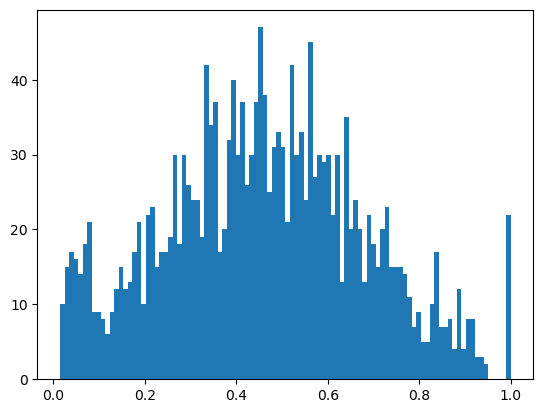

In [107]:
plt.hist([r['bleu-4'] for r in test_results], bins=100);
np.mean([r['bleu-4'] for r in test_results]), np.median([r['bleu-4'] for r in test_results])

In [109]:
dataset.set_split('val')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       #device=args.device
                                      )
batch_dict = next(batch_generator)

#model = model.eval().to(args.device)
sampler = NMTSampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

In [110]:
all_results = []
for i in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [111]:
top_results = [x for x in all_results if x['bleu-4']>0.1]
len(top_results)

61

In [112]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_lengths=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'])
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}
    
def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

In [113]:
results = get_all_sentences(vectorizer, batch_dict, 1)
results

{'source': "you 're the only person i know who ca n't swim .",
 'truth': 'tu es la seule personne que je connaisse qui ne sache pas nager .',
 'sampled': 'vous es la seule personne que je connaisse qui vous sache pas la .'}

----------------------------------
#### 샘플링 수행

In [124]:
class NMTDecoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size, bos_index):
        """
        매개변수:
            num_embeddings (int): 임베딩 개수는 타깃 어휘 사전에 있는 고유한 단어의 개수이다
            embedding_size (int): 임베딩 벡터 크기
            rnn_hidden_size (int): RNN 은닉 상태 크기
            bos_index(int): begin-of-sequence 인덱스
        """
        super(NMTDecoder, self).__init__()
        self._rnn_hidden_size = rnn_hidden_size
        self.target_embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                             embedding_dim=embedding_size, 
                                             padding_idx=0)
        self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size, 
                                   rnn_hidden_size)
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_embeddings)
        self.bos_index = bos_index
        self._sampling_temperature = 3
        
    # Begin_of_sequence 인덱스 벡터 반환
    def _init_indices(self, batch_size) :
        return torch.ones(batch_size, dtype=torch.int64) * self.bos_index
    
    # 문맥 벡터 초기화하기 위한 0벡터 반환
    def _init_context_vectors(self, batch_size):
        return torch.zeros(batch_size, self._rnn_hidden_size)
    
    def forward(self, encoder_state, initial_hidden_state, target_sequence, sample_probability=0.0):
        if target_sequence is None:
            sample_probability = 1.0
        else:
            # 가정: 첫 번째 차원은 배치 차원입니다
            # 즉 입력은 (Batch, Seq)
            # 시퀀스에 대해 반복해야 하므로 (Seq, Batch)로 차원을 바꿉니다
            target_sequence = target_sequence.permute(1, 0)
            output_sequence_size = target_sequence.size(0)
        
        # 주어진 인코더의 은닉 상태를 초기 은닉 상태로 사용합니다
        h_t = self.hidden_map(initial_hidden_state)
        
        batch_size = encoder_state.size(0)
        # 문맥 벡터를 0으로 초기화합니다
        context_vectors = self._init_context_vectors(batch_size)
        # 첫 단어 y_t를 BOS로 초기화합니다
        y_t_index = self._init_indices(batch_size)
        
        h_t = h_t.to(encoder_state.device)
        y_t_index = y_t_index.to(encoder_state.device)
        context_vectors = context_vectors.to(encoder_state.device)

        output_vectors = []
        self._cached_p_attn = []
        self._cached_ht = []
        self._cached_decoder_state = encoder_state.cpu().detach().numpy()
        
        for i in range(output_sequence_size):
            # 스케줄링된 샘플링 사용 여부
            use_sample = np.random.random() < sample_probability
            if not use_sample:
                y_t_index = target_sequence[i]
                
            # 단계 1: 단어를 임베딩하고 이전 문맥과 연결합니다
            y_input_vector = self.target_embedding(y_t_index)
            rnn_input = torch.cat([y_input_vector, context_vectors], dim=1)
            
            # 단계 2: GRU를 적용하고 새로운 은닉 벡터를 얻습니다
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t.cpu().detach().numpy())
            
            # 단계 3: 현재 은닉 상태를 사용해 인코더의 상태를 주목합니다
            context_vectors, p_attn, _ = verbose_attention(encoder_state_vectors=encoder_state, 
                                                           query_vector=h_t)
            
            # 부가 작업: 시각화를 위해 어텐션 확률을 저장합니다
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())
            
            # 단계 4: 현재 은닉 상태와 문맥 벡터를 사용해 다음 단어를 예측합니다
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(F.dropout(prediction_vector, 0.3))
            
            
            # 샘플링 수행
            if use_sample:
                p_y_t_index = F.softmax(score_for_y_t_index * self._sampling_temperature, dim=1) # 뾰족 분포 생성
                # _, y_t_index = torch.max(p_y_t_index, 1) # 최댓값 예측, 확률이 가장 높은 단어
                y_t_index = torch.multinomial(p_y_t_index, 1).squeeze() # 확률에 비례하여 다항분포에서 인덱스 샘플링
            
            # 부가 작업: 예측 성능 점수를 기록
            output_vectors.append(score_for_y_t_index)
            
        output_vectors = torch.stack(output_vectors).permute(1, 0, 2)
        
        return output_vectors

In [129]:
class NMTModel(nn.Module):
    def __init__(self, source_vocab_size, source_embedding_size, 
                 target_vocab_size, target_embedding_size, encoding_size, 
                 target_bos_index):
        super(NMTModel, self).__init__()
        self.encoder = NMTEncoder(num_embeddings=source_vocab_size, 
                                  embedding_size=source_embedding_size,
                                  rnn_hidden_size=encoding_size)
        decoding_size = encoding_size * 2
        self.decoder = NMTDecoder(num_embeddings=target_vocab_size, 
                                  embedding_size=target_embedding_size, 
                                  rnn_hidden_size=decoding_size,
                                  bos_index=target_bos_index)
    
    
    def forward(self, x_source, x_source_lengths, target_sequence, sample_probability=0.0):
        encoder_state, final_hidden_states = self.encoder(x_source, x_source_lengths)
        decoded_states = self.decoder(encoder_state=encoder_state, 
                                      initial_hidden_state=final_hidden_states, 
                                      target_sequence=target_sequence, 
                                      sample_probability=sample_probability)
        return decoded_states

In [130]:
args = Namespace(dataset_csv="./Data/simplest_eng_fra.csv",
                 vectorizer_file="vectorizer.json",
                 model_state_file="model8.pth",
                 save_dir="./",
                 reload_from_files=False,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=32,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=24, 
                 target_embedding_size=24,
                 encoding_size=32,
                 catch_keyboard_interrupt=True)

In [131]:
dataset = NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
vectorizer = dataset.get_vectorizer()

model = NMTModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

In [132]:
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)

In [133]:
for epoch_index in range(args.num_epochs):
    sample_probability = (20 + epoch_index) / args.num_epochs

    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_nmt_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           #device=args.device
                                          )
    running_loss = 0.0
    running_acc = 0.0
    model.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = model(batch_dict['x_source'],
                      batch_dict['x_source_length'],
                      batch_dict['x_target'],
                      sample_probability = sample_probability)
        loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
        loss.backward()
        optimizer.step()
        
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        
    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)
    
    
    dataset.set_split('val')
    batch_generator = generate_nmt_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           #device=args.device
                                          )
    running_loss = 0.
    running_acc = 0.
    model.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = model(batch_dict['x_source'], 
                       batch_dict['x_source_length'], 
                       batch_dict['x_target'],
                       sample_probability=sample_probability)

        loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        
    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    train_state = update_train_state(args=args, model=model, 
                                     train_state=train_state)

    scheduler.step(train_state['val_loss'][-1])

    if train_state['stop_early']:
        break

In [135]:
dataset.set_split('val')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       #device=args.device
                                      )
batch_dict = next(batch_generator)

model = model.eval()#.to(args.device)
sampler = NMTSampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

In [138]:
all_results = []
for i in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [139]:
top_results = [x for x in all_results if x['bleu-4']>0.5]
len(top_results)

8

In [140]:
results = get_all_sentences(vectorizer, batch_dict, 1)
results

{'source': "i 'm willing to help you if you want me to .",
 'truth': "je suis disposé à t'aider , si tu veux que je le fasse .",
 'sampled': 'je suis prêt de vous vous vous vous avais vous vous vous fasse .'}

* 샘플링된 것의 각 미니배치는 텐서 4개로 구성
    - 소스 시퀀스의 정수 행렬 1 / 타깃 시퀀스의 정수 행렬 2 (하나는 어긋난 시퀀스) / 소스 시퀀스 길이의 정수 벡터 1
    
* 두 버전의 모델이 타깃 시퀀스를 다루는 방법이 다르다.
    - 샘플링 X : 제공된 타깃 시퀀스를 타임 스텝마다 디코더의 입력으로 사용
    - 샘플링 O : 스케줄링된 샘플링 사용해 모델이 자체 예측을 만들어 디코더의 입력으로 사용